In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)

import numpy as np
np.random.seed = 42

# Categorical nuisance

In [702]:
from carl.distributions import Mixture, MultivariateNormal

p = MultivariateNormal(mu=np.array([0., 0.]), sigma=np.eye(2))
q0 = MultivariateNormal(mu=np.array([1., -1.]), sigma=np.eye(2))
q1 = MultivariateNormal(mu=np.array([1., 1]), sigma=np.eye(2))
q2 = MultivariateNormal(mu=np.array([1., 3.]), sigma=np.eye(2))
q_full = Mixture(components=[q0, q1, q2])

In [703]:
from keras.utils import np_utils

n_samples = 50000
n_samples //= (2 * 3)

X0 = np.vstack([p.rvs(n_samples), 
                q0.rvs(n_samples)])
y0 = np.zeros(len(X0))
y0[len(X0) // 2:] = 1

X1 = np.vstack([p.rvs(n_samples), 
                q1.rvs(n_samples)])
y1 = np.zeros(len(X1))
y1[len(X1) // 2:] = 1

X2 = np.vstack([p.rvs(n_samples), 
                q2.rvs(n_samples)])
y2 = np.zeros(len(X2))
y2[len(X2) // 2:] = 1

X = np.vstack([X0, X1, X2])
y = np.concatenate([y0, y1, y2])

z = np.zeros(len(X))
z[len(X0):] = 1
z[2*len(X0):] = 2
z = np_utils.to_categorical(z.astype(np.int))

In [704]:
X.shape, y.shape, z.shape

((49998, 2), (49998,), (49998, 3))

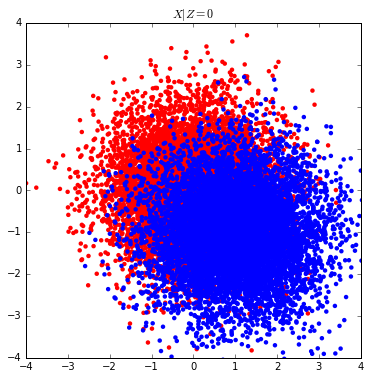

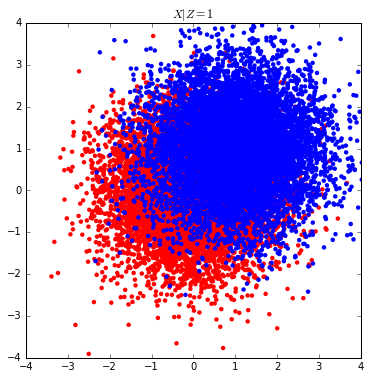

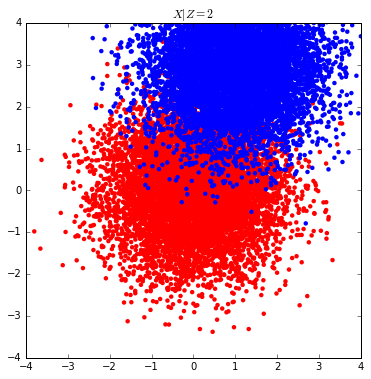

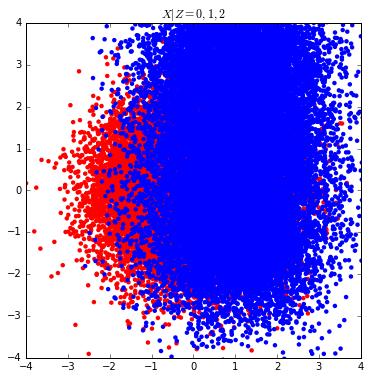

In [705]:
plt.title("$X|Z=0$")
plt.scatter(X0[y0==0, 0], X0[y0==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X0[y0==1, 0], X0[y0==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

plt.title("$X|Z=1$")
plt.scatter(X1[y1==0, 0], X1[y1==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X1[y1==1, 0], X1[y1==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

plt.title("$X|Z=2$")
plt.scatter(X2[y2==0, 0], X2[y2==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X2[y2==1, 0], X2[y2==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

plt.title("$X|Z=0,1,2$")
plt.scatter(X[y==0, 0], X[y==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X[y==1, 0], X[y==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

In [706]:
from scipy.stats import entropy

# when Z is marginalized out, the best classifier is p.pdf(X) / (p.pdf(X) + q_full.pdf(X)

probas = p.pdf(X) / (p.pdf(X) + q_full.pdf(X))
probas = np.hstack([probas.reshape(-1, 1), 
                    (1.-probas).reshape(-1, 1)])
min_Lf = np.mean([entropy(p_i) for p_i in probas])   # lower bound on Lf
min_Lr = entropy([1. / 3] * 3)

In [707]:
min_Lf, min_Lr

(0.47424107260102599, 1.0986122886681096)

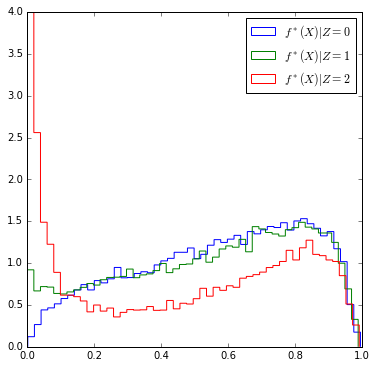

In [708]:
# best model trained on union
d = p.pdf(X0) / (p.pdf(X0) + q_full.pdf(X0))
plt.hist(d, bins=50, histtype="step", label="$f^*(X)|Z=0$", normed=1)
d = p.pdf(X1) / (p.pdf(X1) + q_full.pdf(X1))
plt.hist(d, bins=50, histtype="step", label="$f^*(X)|Z=1$", normed=1)
d = p.pdf(X2) / (p.pdf(X2) + q_full.pdf(X2))
plt.hist(d, bins=50, histtype="step", label="$f^*(X)|Z=2$", normed=1)
plt.legend(loc="best")
plt.ylim(0, 4.)
plt.show()

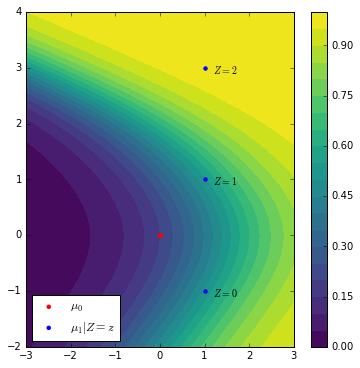

In [726]:
from matplotlib.mlab import griddata

X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 2.5

y_pred = q_full.pdf(X_test) / (p.pdf(X_test) + q_full.pdf(X_test))

xi = np.linspace(-3., 3., 100)
yi = np.linspace(-2, 4, 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 
plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mu_0$")
plt.scatter([1], [-1], c="blue", linewidths=0, label=r"$\mu_1|Z=z$")
plt.scatter([1], [1], c="blue", linewidths=0)
plt.scatter([1], [3], c="blue", linewidths=0)
plt.scatter([0], [0], c="red", linewidths=0)
plt.text(1.2, -1-0.1, "$Z=0$", color="k")
plt.text(1.2, 3-0.1, "$Z=2$", color="k")
plt.text(1.2, 1-0.1, "$Z=1$", color="k")
plt.xlim(-3,3)
plt.ylim(-2,4)
plt.legend(loc="lower left", scatterpoints=1)
plt.show()

In [714]:
from sklearn.metrics import roc_auc_score
(roc_auc_score(y0, q_full.pdf(X0) / (p.pdf(X0) + q_full.pdf(X0))), 
 roc_auc_score(y1, q_full.pdf(X1) / (p.pdf(X1) + q_full.pdf(X1))),
 roc_auc_score(y1, q_full.pdf(X2) / (p.pdf(X2) + q_full.pdf(X2))),
 roc_auc_score(y, q_full.pdf(X) / (p.pdf(X) + q_full.pdf(X))))

(0.77164896748276024,
 0.80618560875880374,
 0.97216519406006052,
 0.8489879384766974)

# Adversarial training of f

In [715]:
from sklearn.cross_validation import train_test_split

X_train, X_valid, y_train, y_valid, z_train, z_valid = train_test_split(X, y, z, test_size=5000)

In [716]:
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(20, activation="tanh")(inputs)
Dx = Dense(20, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

Rx = D(inputs)
Rx = Dense(20, activation="tanh")(Rx)
Rx = Dense(20, activation="relu")(Rx)
Rx = Dense(z.shape[1], activation="softmax")(Rx)
R = Model(input=[inputs], output=[Rx])

In [717]:
R.predict(X_train[:3])

array([[ 0.34433272,  0.30982986,  0.34583741],
       [ 0.34419188,  0.31013647,  0.34567165],
       [ 0.34485653,  0.30868775,  0.34645572]], dtype=float32)

In [718]:
from keras.optimizers import SGD
import keras.backend as K

lam = 10.0

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        return c * K.binary_crossentropy(y_pred, y_true)
    return loss_D

def make_loss_R(c):
    def loss_R(z_true, z_pred):
        return c * K.categorical_crossentropy(z_pred, z_true)
    return loss_R

opt_D = SGD()
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)

opt_DRf = SGD(momentum=0) 
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
DRf.compile(loss=[make_loss_D(c=1.0), 
                  make_loss_R(c=-lam)],   # compare with c=0.0, ie. when no there is no adversary
            optimizer=opt_DRf)

opt_DfR = SGD(momentum=0) 
DfR = Model(input=[inputs], output=[R(inputs)])
DfR.compile(loss=[make_loss_R(c=1.0)], 
            optimizer=opt_DfR)

In [719]:
DRf.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_35 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
model_160 (Model)                (None, 1)             501         input_35[0][0]                   
____________________________________________________________________________________________________
model_161 (Model)                (None, 3)             1024        input_35[0][0]                   
Total params: 1525
____________________________________________________________________________________________________


In [720]:
DfR.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_35 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
model_161 (Model)                (None, 3)             1024        input_35[0][0]                   
Total params: 1024
____________________________________________________________________________________________________


In [721]:
DRf.predict(X_train[:3])

[array([[ 0.4922848 ],
        [ 0.4856365 ],
        [ 0.51712018]], dtype=float32),
 array([[ 0.34433272,  0.30982986,  0.34583741],
        [ 0.34419188,  0.31013647,  0.34567165],
        [ 0.34485653,  0.30868775,  0.34645572]], dtype=float32)]

In [722]:
DfR.predict(X_train[:3])

array([[ 0.34433272,  0.30982986,  0.34583741],
       [ 0.34419188,  0.31013647,  0.34567165],
       [ 0.34485653,  0.30868775,  0.34645572]], dtype=float32)

In [723]:
# Pretraining of D
D.trainable = True
R.trainable = False
D.fit(X_train, y_train, nb_epoch=10)

Epoch 1/10
44998/44998 [==============================] - 0s - loss: 0.5474     
Epoch 2/10
44998/44998 [==============================] - 0s - loss: 0.4857     
Epoch 3/10
44998/44998 [==============================] - 0s - loss: 0.4794     
Epoch 4/10
44998/44998 [==============================] - 0s - loss: 0.4785     
Epoch 5/10
44998/44998 [==============================] - 0s - loss: 0.4780     
Epoch 6/10
44998/44998 [==============================] - 0s - loss: 0.4776     
Epoch 7/10
44998/44998 [==============================] - 0s - loss: 0.4771     
Epoch 8/10
44998/44998 [==============================] - 0s - loss: 0.4768     
Epoch 9/10
44998/44998 [==============================] - 0s - loss: 0.4764     
Epoch 10/10
44998/44998 [==============================] - 0s - loss: 0.4760     


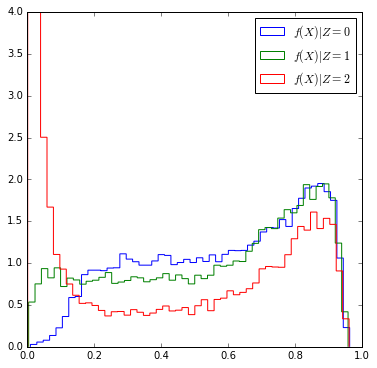

In [724]:
plt.hist(1. - D.predict(X0), bins=50, normed=1, histtype="step", label="$f(X)|Z=0$")
plt.hist(1. - D.predict(X1), bins=50, normed=1, histtype="step", label="$f(X)|Z=1$")
plt.hist(1. - D.predict(X2), bins=50, normed=1, histtype="step", label="$f(X)|Z=2$")
plt.legend(loc="best")
plt.ylim(0, 4.)
plt.show()

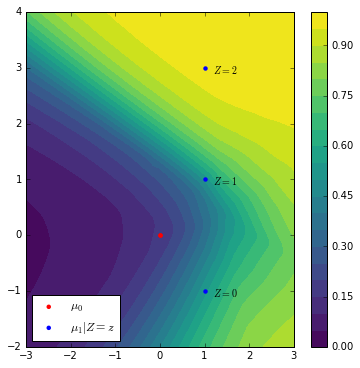

In [727]:
from matplotlib.mlab import griddata

X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 2.5

y_pred = D.predict(X_test).ravel()

xi = np.linspace(-3., 3., 100)
yi = np.linspace(-2, 4, 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 
plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mu_0$")
plt.scatter([1], [-1], c="blue", linewidths=0, label=r"$\mu_1|Z=z$")
plt.scatter([1], [1], c="blue", linewidths=0)
plt.scatter([1], [3], c="blue", linewidths=0)
plt.scatter([0], [0], c="red", linewidths=0)
plt.text(1.2, -1-0.1, "$Z=0$", color="k")
plt.text(1.2, 3-0.1, "$Z=2$", color="k")
plt.text(1.2, 1-0.1, "$Z=1$", color="k")
plt.xlim(-3,3)
plt.ylim(-2,4)
plt.legend(loc="lower left", scatterpoints=1)
plt.show()

In [728]:
# Pretraining of R
D.trainable = False
R.trainable = True
DfR.fit(X_train, z_train, nb_epoch=10)

Epoch 1/10
44998/44998 [==============================] - 0s - loss: 1.0735     
Epoch 2/10
44998/44998 [==============================] - 0s - loss: 1.0479     
Epoch 3/10
44998/44998 [==============================] - 0s - loss: 1.0305     
Epoch 4/10
44998/44998 [==============================] - 0s - loss: 1.0172     
Epoch 5/10
44998/44998 [==============================] - 0s - loss: 1.0070     
Epoch 6/10
44998/44998 [==============================] - 0s - loss: 0.9991     
Epoch 7/10
44998/44998 [==============================] - 0s - loss: 0.9935     
Epoch 8/10
44998/44998 [==============================] - 0s - loss: 0.9897     
Epoch 9/10
44998/44998 [==============================] - 0s - loss: 0.9870     
Epoch 10/10
44998/44998 [==============================] - 0s - loss: 0.9851     


In [729]:
from IPython import display

def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    ax1 = plt.subplot(311)   
    plt.axhline(y=min_Lf, ls="dashed")
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")
    plt.legend(loc="upper right")
    
    ax2 = plt.subplot(312, sharex=ax1) 
    plt.axhline(y=min_Lr, ls="dashed")
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.legend(loc="upper right")
    
    ax3 = plt.subplot(313, sharex=ax1)
    plt.axhline(y=min_Lf - lam*min_Lr, ls="dashed")
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.legend(loc="upper right")
    
    plt.show()   

In [730]:
losses = {"L_f": [], "L_r": [], "L_f - L_r": []}

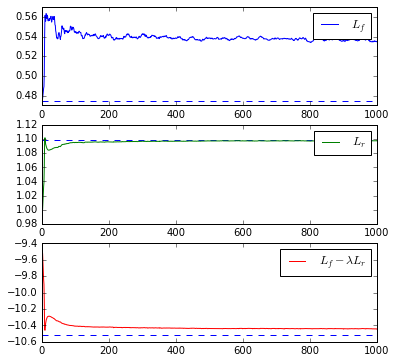

In [731]:
batch_size = 128

for i in range(1001):
    l = DRf.evaluate(X_valid, [y_valid, z_valid], verbose=0)    
    losses["L_f - L_r"].append(l[0][None][0])
    losses["L_f"].append(l[1][None][0])
    losses["L_r"].append(-l[2][None][0])
    
    if i % 50 == 0:
        plot_losses(i, losses)
    
    # Fit D
    D.trainable = True
    R.trainable = False
    indices = np.random.permutation(len(X_train))[:batch_size]
    DRf.train_on_batch(X_train[indices], [y_train[indices], z_train[indices]])
    
    # Fit R
    D.trainable = False
    R.trainable = True
    
    for j in range(100):
        indices = np.random.permutation(len(X_train))[:batch_size]
        DfR.train_on_batch(X_train[indices], z_train[indices])

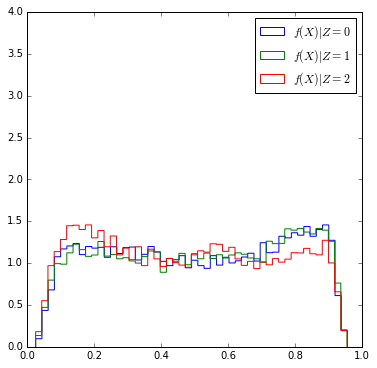

In [732]:
plt.hist(1. - D.predict(X0), bins=50, normed=1, histtype="step", label="$f(X)|Z=0$")
plt.hist(1. - D.predict(X1), bins=50, normed=1, histtype="step", label="$f(X)|Z=1$")
plt.hist(1. - D.predict(X2), bins=50, normed=1, histtype="step", label="$f(X)|Z=2$")
plt.legend(loc="best")
plt.ylim(0, 4.)
plt.show()

Looks pivotal!

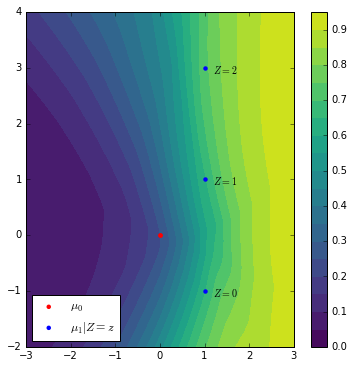

In [733]:
from matplotlib.mlab import griddata

X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 2.5

y_pred = D.predict(X_test).ravel()

xi = np.linspace(-3., 3., 100)
yi = np.linspace(-2, 4, 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 
plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mu_0$")
plt.scatter([1], [-1], c="blue", linewidths=0, label=r"$\mu_1|Z=z$")
plt.scatter([1], [1], c="blue", linewidths=0)
plt.scatter([1], [3], c="blue", linewidths=0)
plt.scatter([0], [0], c="red", linewidths=0)
plt.text(1.2, -1-0.1, "$Z=0$", color="k")
plt.text(1.2, 3-0.1, "$Z=2$", color="k")
plt.text(1.2, 1-0.1, "$Z=1$", color="k")
plt.xlim(-3,3)
plt.ylim(-2,4)
plt.legend(loc="lower left", scatterpoints=1)
plt.show()

In [734]:
from sklearn.metrics import roc_auc_score
(roc_auc_score(y0, D.predict(X0)), 
 roc_auc_score(y1, D.predict(X1)), 
 roc_auc_score(y2, D.predict(X2)), 
 roc_auc_score(y, D.predict(X)))

(0.78523307738981818,
 0.78204099722851272,
 0.83725350934114162,
 0.80125664964996135)

In [736]:
print(min_Lr)

probas = DfR.predict(X_valid)
mean_entropy_f = np.mean([entropy(q) for q in probas])
print(mean_entropy_f)

1.09861228867
1.0963


---

# Continuous nuisance

In [24]:
np.random.seed = 777
from carl.distributions import Mixture, MultivariateNormal, Uniform

p0 = MultivariateNormal(mu=np.array([0., 0.]), sigma=np.eye(2))
p1 = MultivariateNormal(mu=np.array([1., -1.]), sigma=np.eye(2))
pz = Uniform(low=0, high=4.0)

In [25]:
n_samples = 50000

X0 = p0.rvs(n_samples // 2)
X1 = p1.rvs(n_samples // 2)
z = pz.rvs(n_samples).ravel()
X1[:, 1] += z[n_samples // 2:]
X1[:, 1] -= 1.0

X = np.vstack([X0, X1])
y = np.zeros(n_samples)
y[n_samples // 2:] = 1

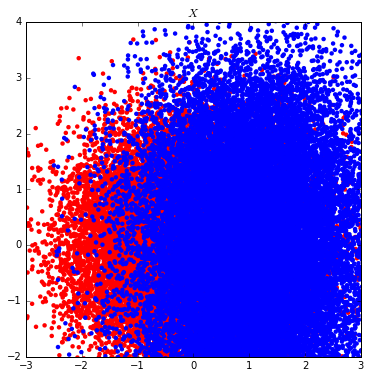

In [26]:
plt.title("$X$")
plt.scatter(X[y==0, 0], X[y==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X[y==1, 0], X[y==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-3,3)
plt.ylim(-2,4)
plt.show()

# Adversarial training of f

In [204]:
from sklearn.cross_validation import train_test_split

X_train, X_valid, y_train, y_valid, z_train, z_valid = train_test_split(X, y, z, test_size=5000)

In [205]:
import keras.backend as K
from keras.layers import Input, Dense, Merge, Lambda
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(20, activation="tanh")(inputs)
Dx = Dense(20, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

# XXX: switch for a mixture density network
# http://www.cedar.buffalo.edu/~srihari/CSE574/Chap5/Chap5.7-MixDensityNetworks.pdf
Rx = D(inputs)
Rx = Dense(20, activation="relu")(Rx)
Rx = Dense(20, activation="relu")(Rx)
Rx = Dense(20, activation="relu")(Rx)
mu = Dense(1, activation="tanh")(Rx)  
mu = Lambda(lambda x: (x+1.0)*2)(mu)   
sigma = Dense(1, activation=K.exp)(Rx)
Rx = Merge(mode="concat")([mu, sigma])

R = Model(input=[inputs], output=[Rx])

In [206]:
R.predict(X_train[:3])

array([[ 2.06275249,  1.07496107],
       [ 2.0767529 ,  1.09245336],
       [ 2.07583928,  1.09130311]], dtype=float32)

In [207]:
from keras.optimizers import SGD
import keras.backend as K
import theano.tensor as T

lam = 10.0

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        return c * K.binary_crossentropy(y_pred, y_true)
    return loss_D

def make_loss_R(c):
    def loss_R(z_true, z_pred):
        a = 0.0
        b = 4.0
        
        z = z_true.ravel()
        mu = z_pred[:, 0].ravel() 
        sigma = z_pred[:, 1].ravel() 
        
        ll = (-K.log(sigma) 
              -np.log(np.sqrt(2. * np.pi)) 
              -((z - mu) ** 2 / (2. * sigma ** 2))
              +np.log(2.)
              -K.log(T.erf((b - mu) / (sigma * np.sqrt(2.))) - 
                     T.erf((a - mu) / (sigma * np.sqrt(2.)))))
        
        return -c * ll.mean()
    
    return loss_R

opt_D = SGD()
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)

opt_DRf = SGD(momentum=0.0)
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
DRf.compile(loss=[make_loss_D(c=1.0), 
                  make_loss_R(c=-lam)],   # compare with c=0.0, ie. when no there is no adversary
            optimizer=opt_DRf)

opt_DfR = SGD(momentum=0.0)
DfR = Model(input=[inputs], output=[R(inputs)])
DfR.compile(loss=[make_loss_R(c=1.0)], 
            optimizer=opt_DfR)

In [208]:
DRf.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
model_41 (Model)                 (None, 1)             501         input_11[0][0]                   
____________________________________________________________________________________________________
model_42 (Model)                 (None, 2)             1423        input_11[0][0]                   
Total params: 1924
____________________________________________________________________________________________________


In [209]:
DfR.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
model_42 (Model)                 (None, 2)             1423        input_11[0][0]                   
Total params: 1423
____________________________________________________________________________________________________


In [210]:
DRf.predict(X_train[:3])

[array([[ 0.42891565],
        [ 0.52469498],
        [ 0.51844388]], dtype=float32), array([[ 2.06275249,  1.07496107],
        [ 2.0767529 ,  1.09245336],
        [ 2.07583928,  1.09130311]], dtype=float32)]

In [211]:
DfR.predict(X_train[:3])

array([[ 2.06275249,  1.07496107],
       [ 2.0767529 ,  1.09245336],
       [ 2.07583928,  1.09130311]], dtype=float32)

In [184]:
# # Pretraining of D
# D.trainable = True
# R.trainable = False
# D.fit(X_train, y_train, nb_epoch=50)
# min_Lf = D.evaluate(X_valid, y_valid)

Epoch 1/50
45000/45000 [==============================] - 0s - loss: 0.5765     
Epoch 2/50
45000/45000 [==============================] - 0s - loss: 0.5540     
Epoch 3/50
45000/45000 [==============================] - 0s - loss: 0.5519     
Epoch 4/50
45000/45000 [==============================] - 0s - loss: 0.5511     
Epoch 5/50
45000/45000 [==============================] - 0s - loss: 0.5505     
Epoch 6/50
45000/45000 [==============================] - 0s - loss: 0.5500     
Epoch 7/50
45000/45000 [==============================] - 0s - loss: 0.5497     
Epoch 8/50
45000/45000 [==============================] - 0s - loss: 0.5493     
Epoch 9/50
45000/45000 [==============================] - 0s - loss: 0.5491     
Epoch 10/50
45000/45000 [==============================] - 0s - loss: 0.5489     
Epoch 11/50
45000/45000 [==============================] - 0s - loss: 0.5489     
Epoch 12/50
45000/45000 [==============================] - 0s - loss: 0.5488     
Epoch 13/50
45000/45000 [

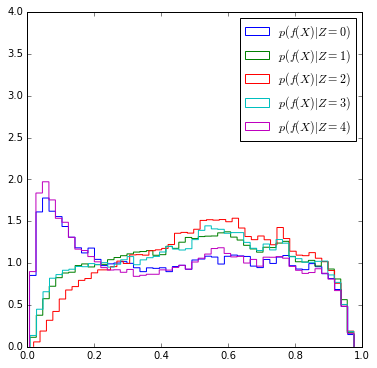

In [185]:
def make_X(n_samples, z):
    X0 = p0.rvs(n_samples // 2)
    X1 = p1.rvs(n_samples // 2)
    X1[:, 1] += z
    X1[:, 1] -= 1.0
    X = np.vstack([X0, X1])
    y = np.zeros(n_samples)
    y[n_samples // 2:] = 1
    return X

plt.hist(1. - D.predict(make_X(50000, z=0)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=0)$")
plt.hist(1. - D.predict(make_X(50000, z=1)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=1)$")
plt.hist(1. - D.predict(make_X(50000, z=2)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=2)$")
plt.hist(1. - D.predict(make_X(50000, z=3)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=3)$")
plt.hist(1. - D.predict(make_X(50000, z=4)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=4)$")
plt.legend(loc="best")
plt.ylim(0,4)
plt.savefig("f-plain.pdf")
plt.show()

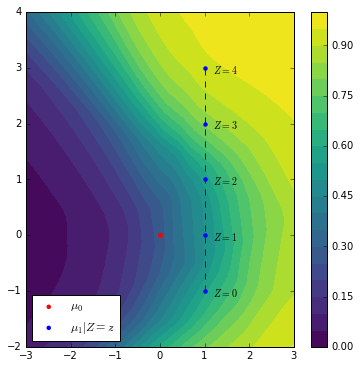

In [187]:
X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 2.5
y_pred = D.predict(X_test).ravel()

from matplotlib.mlab import griddata
xi = np.linspace(-3., 3., 100)
yi = np.linspace(-2, 4, 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 
plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mu_0$")
plt.scatter([1], [-1], c="blue", linewidths=0, label=r"$\mu_1|Z=z$")
plt.scatter([1], [0], c="blue", linewidths=0)
plt.scatter([1], [1], c="blue", linewidths=0)
plt.scatter([1], [2], c="blue", linewidths=0)
plt.scatter([1], [3], c="blue", linewidths=0)
plt.scatter([0], [0], c="red", linewidths=0)
plt.vlines(1, -1, 3, color="blue", linestyles="dashed")
plt.text(1.2, -1-0.1, "$Z=0$", color="k")
plt.text(1.2, -1+1-0.1, "$Z=1$", color="k")
plt.text(1.2, -1+2-0.1, "$Z=2$", color="k")
plt.text(1.2, -1+3-0.1, "$Z=3$", color="k")
plt.text(1.2, 3-0.1, "$Z=4$", color="k")
plt.xlim(-3,3)
plt.ylim(-2,4)
plt.legend(loc="lower left", scatterpoints=1)
plt.savefig("surface-plain.pdf")
plt.show()

In [212]:
from IPython import display

min_Lr = np.log(4.0)

def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    ax1 = plt.subplot(311)   
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")
    plt.legend(loc="upper right")
    
    ax2 = plt.subplot(312, sharex=ax1) 
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.legend(loc="upper right")
    
    ax3 = plt.subplot(313, sharex=ax1)
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.legend(loc="upper right")
    
    #plt.savefig("training.pdf")
    
    plt.show()  

In [213]:
losses = {"L_f": [], "L_r": [], "L_f - L_r": []}

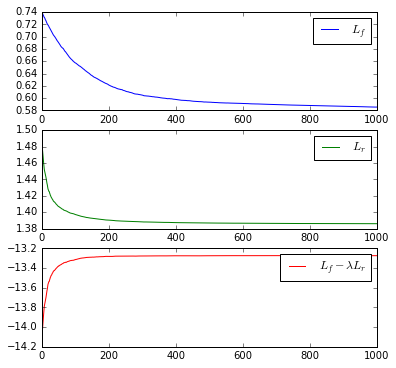

In [214]:
batch_size = 128

for i in range(1001):
    l = DRf.evaluate(X_valid, [y_valid, z_valid], verbose=0)    
    losses["L_f - L_r"].append(l[0][None][0])
    losses["L_f"].append(l[1][None][0])
    losses["L_r"].append(-l[2][None][0])
    
    if i % 50 == 0:
        plot_losses(i, losses)
    
    # Fit D
    D.trainable = True
    R.trainable = False
    indices = np.random.permutation(len(X_train))[:batch_size]
    DRf.train_on_batch(X_train[indices], [y_train[indices], z_train[indices]])
    
    # Fit R
    D.trainable = False
    R.trainable = True
    
    for j in range(1):
        indices = np.random.permutation(len(X_train))[:batch_size]
        DfR.train_on_batch(X_train[indices], z_train[indices])

In [220]:
#D.load_weights("D.weights")

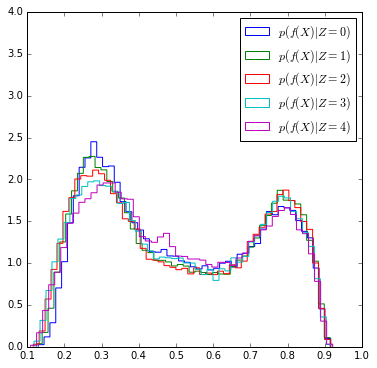

In [216]:
plt.hist(1. - D.predict(make_X(50000, z=0)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=0)$")
plt.hist(1. - D.predict(make_X(50000, z=1)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=1)$")
plt.hist(1. - D.predict(make_X(50000, z=2)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=2)$")
plt.hist(1. - D.predict(make_X(50000, z=3)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=3)$")
plt.hist(1. - D.predict(make_X(50000, z=4)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=4)$")
plt.legend(loc="best")
plt.ylim(0,4)
plt.savefig("f-adversary.pdf")
plt.show()

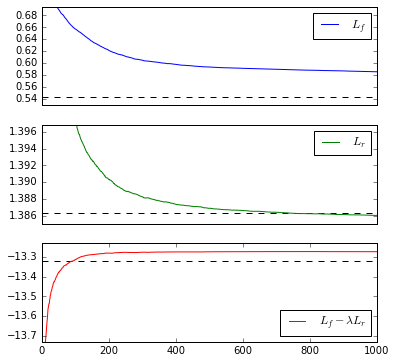

In [218]:
def plot_losses_final(losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    n_iter = len(np.array(losses["L_f"]))-1

    ax1 = plt.subplot(311)  
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")   
    plt.hlines(min_Lf, 0, n_iter, linestyles="dashed")
    low = min(min_Lf, values.min())
    high = max(min_Lf, values.max())
    high = high - (high-low) * 0.3
    low, high = low - (high-low)*0.1, high + (high-low)*0.1
    plt.ylim(low, high)
    plt.xticks([])
    plt.xlim(0, n_iter)
    plt.legend(loc="upper right")
    
    ax2 = plt.subplot(312, sharex=ax1) 
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.hlines(min_Lr, 0, n_iter, linestyles="dashed")
    low = min(min_Lr, values.min())
    high = max(min_Lr, values.max())
    high = high - (high-low) * 0.9
    low, high = low - (high-low)*0.1, high + (high-low)*0.1
    plt.ylim(low, high)
    plt.legend(loc="upper right")
    
    ax3 = plt.subplot(313)
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.hlines(min_Lf - lam*min_Lr, 0, n_iter, linestyles="dashed")
    low = min(min_Lf - lam*min_Lr, values.min())
    high = max(min_Lf - lam*min_Lr, values.max())
    low = low + (high-low) * 0.5
    low, high = low - (high-low)*0.1, high + (high-low)*0.1
    plt.ylim(low, high)
    plt.xlim(0, n_iter)
    plt.legend(loc="lower right")
    
    plt.savefig("training.pdf")
    
    plt.show()  
    
plot_losses_final(losses)

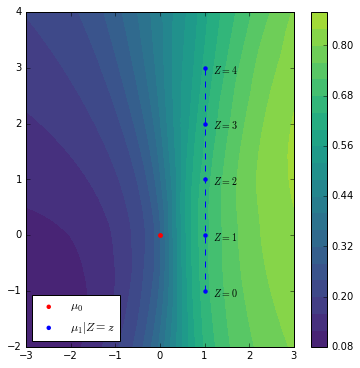

In [219]:
X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 2.5
y_pred = D.predict(X_test).ravel()

from matplotlib.mlab import griddata
xi = np.linspace(-3., 3., 100)
yi = np.linspace(-2, 4, 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 
plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mu_0$")
plt.scatter([1], [-1], c="blue", linewidths=0, label=r"$\mu_1|Z=z$")
plt.scatter([1], [0], c="blue", linewidths=0)
plt.scatter([1], [1], c="blue", linewidths=0)
plt.scatter([1], [2], c="blue", linewidths=0)
plt.scatter([1], [3], c="blue", linewidths=0)
plt.scatter([0], [0], c="red", linewidths=0)
plt.vlines(1, -1, 3, color="blue", linestyles="dashed")
plt.text(1.2, -1-0.1, "$Z=0$", color="k")
plt.text(1.2, -1+1-0.1, "$Z=1$", color="k")
plt.text(1.2, -1+2-0.1, "$Z=2$", color="k")
plt.text(1.2, -1+3-0.1, "$Z=3$", color="k")
plt.text(1.2, 3-0.1, "$Z=4$", color="k")
plt.xlim(-3,3)
plt.ylim(-2,4)
plt.legend(loc="lower left", scatterpoints=1)
plt.savefig("surface-adversary.pdf")
plt.show()

In [175]:
#D.save_weights("D.weights")